### Install and import required packages.

In [1]:
# pip install selenium

In [2]:
# pip install beautifulsoup4

In [3]:
# pip install webdriver-manager

In [4]:
# pip install textstat

In [5]:
# pip install wordcloud

In [6]:
from time import sleep
from bs4 import BeautifulSoup

from math import ceil

from matplotlib import pyplot

from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.draw.dispersion import dispersion_plot
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from statistics import fmean 

from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ExpectedConditions
from selenium.webdriver.support.ui import WebDriverWait

from textstat import flesch_reading_ease

from webdriver_manager.chrome import ChromeDriverManager

from wordcloud import WordCloud

### Create an instance of chrome browser (version 99+) in 'incognito' mode.

In [7]:
# Install and create an chrome service instance
chrome_service = ChromeService(ChromeDriverManager().install())

# Create an web driver instance with relavent options
chrome_options = ChromeOptions()
chrome_options.add_argument("--incognito")
# chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--lang=en")

# Create session using web driver
chrome_driver = webdriver.Chrome(service=chrome_service, options=chrome_options)



====== WebDriver manager ======
Could not get version for google-chrome with the command:  powershell "$ErrorActionPreference='silentlycontinue' ; (Get-Item -Path "$env:PROGRAMFILES\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion ; if (-not $? -or $? -match $error) { (Get-Item -Path "$env:PROGRAMFILES(x86)\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { (Get-Item -Path "$env:LOCALAPPDATA\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { reg query "HKCU\SOFTWARE\Google\Chrome\BLBeacon" /v version } if (-not $? -or $? -match $error) { reg query "HKLM\SOFTWARE\Wow6432Node\Microsoft\Windows\CurrentVersion\Uninstall\Google Chrome" /v version }"
Current google-chrome version is UNKNOWN
Get LATEST chromedriver version for UNKNOWN google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/99.0.4844.51/chromedriver_win32.zip
Driver has been s

### Naivgate to requied URL. Accept consent form if required.

In [8]:
# Google Maps URL - UCD
# url = "https://www.google.com/maps/place/University+College+Dublin/@53.3064642,-6.2276766,17z/data=!3m1!4b1!4m5!3m4!1s0x4867093120c83a63:0x36762af31424bfcf!8m2!3d53.3064642!4d-6.2254879"

# Google Maps URl - Restaurant
url = "https://www.google.com/maps/place/Milano+-+Dawson+Street/@53.344433,-6.2547734,15.54z/data=!4m5!3m4!1s0x0:0x5c020c6bec38bf05!8m2!3d53.3406016!4d-6.2586585"
chrome_driver.get(url)

consent_selector = "//button[@aria-label='Agree to the use of cookies and other data for the purposes described']"
consent_agree_button = chrome_driver.find_element(by=By.XPATH, value=consent_selector);
consent_agree_button.click()

### Navigate to 'review' section and extract required information.

In [9]:
wait = WebDriverWait(chrome_driver, 30)
thread_sleep_time_in_secs = 5
scroll_for_x_mins = 5

# Open sort review menu
sort_review_menu_selector = "//button[@aria-label='Sort reviews']"
sort_review_menu_element = wait.until(ExpectedConditions.element_to_be_clickable((By.XPATH, sort_review_menu_selector)))
sort_review_menu_element.click()

sleep(thread_sleep_time_in_secs)

# Sort by newest reviews
newest_review_selector = "//li[@role='menuitemradio']"
newest_review_element = chrome_driver.find_elements(by=By.XPATH, value=newest_review_selector)[1]
newest_review_element.click()

sleep(thread_sleep_time_in_secs)

# Scroll down page and load as many review as it can in next X mins
scrollable_div = chrome_driver.find_element(by=By.CSS_SELECTOR, value='div.section-scrollbox')
for i in range(12 * scroll_for_x_mins):
    chrome_driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
    sleep(thread_sleep_time_in_secs)
    
# Make sure all reviews are loaded completely
more_text_selector = "//button[@aria-label=' See more ']"
more_text_elements = chrome_driver.find_elements(by=By.XPATH, value=more_text_selector)
for element in more_text_elements:
    element.click()
    
sleep(thread_sleep_time_in_secs)

# Extract required infomation based on CSS selectors
response = BeautifulSoup(chrome_driver.page_source, 'html.parser')
reviews = response.select('span[class="ODSEW-ShBeI-text"]')
reviews = [review.get_text() for review in reviews]

# Terminate session using web driver
chrome_driver.quit()

### Process text and build corpus.

In [10]:
print('Reviews Found: ' + str(len(reviews)) + '\n')

corpus = [review for review in reviews if review != ""]
corpus = ' '.join(corpus)

print('Raw Corpus: \n\n' + corpus)

Reviews Found: 150

Raw Corpus: 

Really enjoyed the food. Food was excellent. Really tasty. However, one male waiter was extremely rude and condescending while taking orders. Also at the end when the bill was payed the receipt was thrown on the table as he walked off Food was amazing! Tons of gf & vegan options! Server was extremely nice & helpful! Completely overpriced.  Nearly 16 euro for a thin based Margharita pizza and 2.30 extra for each of the toppings which were barely there.  Very average food.  Service understated to say the least..............will not be gracing this restaurant with my presence again. Great staff and very good vegan menu. (Translated by Google) Server catastrophic, food correct but for higher price than the average. … Visited while in Dublin. Nice food, good service and a very tasty dessert :-) Staff lovely so nice but just one poor lad put to work in a big area. We were put to sit by the toilets and a fire exit blocked by high chairs. We put on a brave fac

### Analyse corpus.

In [11]:
processed_corpus = corpus.lower()
processed_corpus = word_tokenize(processed_corpus)

total_words = len(processed_corpus)
nltk_words = set(words.words())

processed_corpus = [word for word in processed_corpus if word in nltk_words]
processed_corpus = [word for word in processed_corpus if word not in stopwords.words('english')]
processed_corpus = [word for word in processed_corpus if len(word) > 0]
processed_corpus = [WordNetLemmatizer().lemmatize(word) for word in processed_corpus]

final_corpus = ' '.join(processed_corpus)

# Flesch's reading ease score
flesch_reading_ease_scores = [flesch_reading_ease(review) for review in reviews]
print('Flesch\'s reading ease score (Lexical readability):')
print('Min: ' + str(min(flesch_reading_ease_scores)))
print('Max: ' + str(max(flesch_reading_ease_scores)))
print('Average: ' + str(fmean(flesch_reading_ease_scores)))

# Calculate lexical diversity using Hapax richness method
hapax_richness = (len(processed_corpus) / total_words) * 100
print('\nHapax richness (Lexical diversity): ' + str(hapax_richness))

# Calculate frequency distribution
token_freq_dist = FreqDist(processed_corpus).most_common(25)
print('\nTop 5 common words:\n'+ str(token_freq_dist[:10]))

Flesch's reading ease score (Lexical readability):
Min: -51.03
Max: 206.84
Average: 132.43946666666668

Hapax richness (Lexical diversity): 40.511860174781525

Top 5 common words:
[('food', 35), ('pizza', 28), ('good', 23), ('great', 20), ('service', 19), ('staff', 16), ('friendly', 14), ('nice', 13), ('lovely', 12), ('place', 12)]


### Export corpus and analytical diagrams.

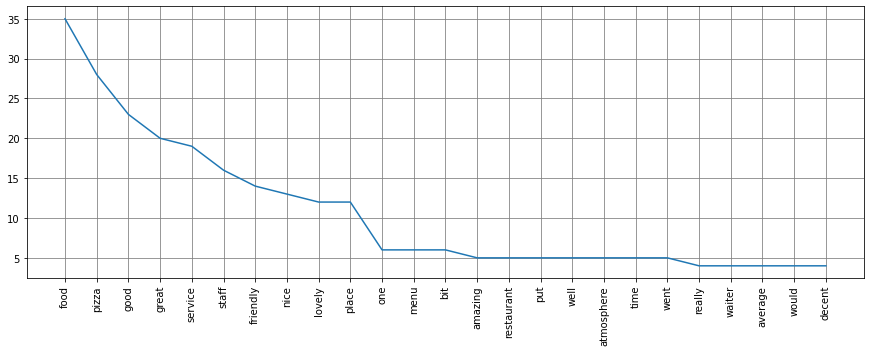

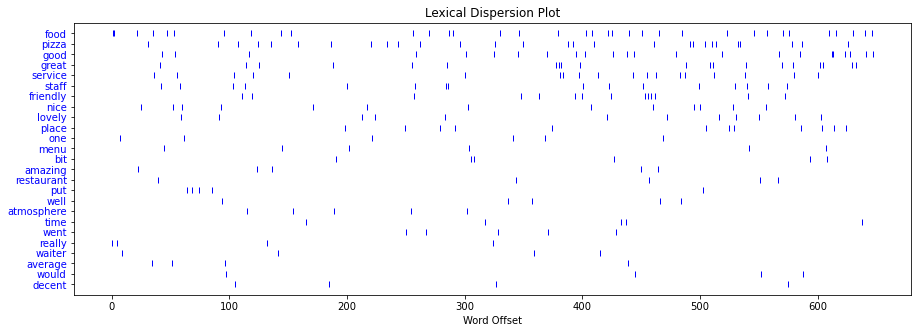

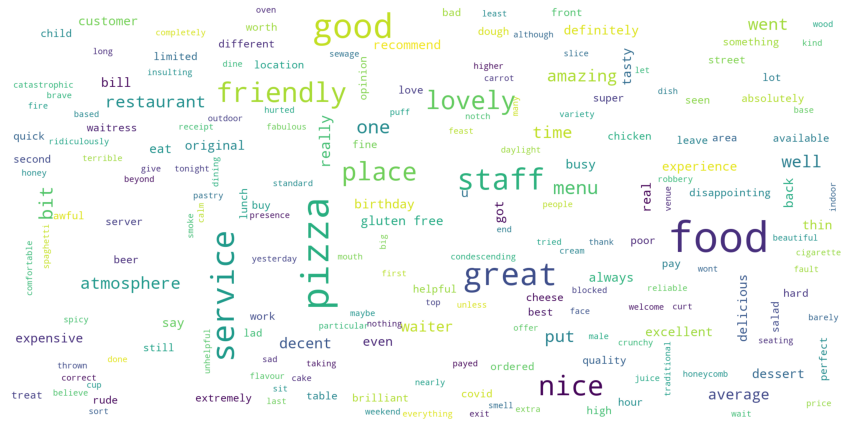

In [12]:
# Export corpus text
with open('corpus.txt', 'w', encoding="utf-8") as corpus_file:
    corpus_file.write(corpus)
    
with open('final_corpus.txt', 'w', encoding="utf-8") as corpus_file:
    corpus_file.write(final_corpus)

# Export frequency distribution
token_freq_dist_zip = list(zip(*token_freq_dist))
x, y = list(token_freq_dist_zip[0]), list(token_freq_dist_zip[1])

pyplot.figure(1, figsize = (15, 5))
pyplot.grid(color='grey', linestyle='-')
pyplot.xticks(rotation=90)
pyplot.plot(x, y)
pyplot.savefig('token_freq_dist.png')
pyplot.show()

#Export dispersion plot
dispersion_plot_figure = pyplot.figure(2, figsize=(15, 5))
dispersion_plot(processed_corpus, x[:25])
dispersion_plot_figure.savefig('dispersion_plot.png')

# Export word cloud
word_cloud = WordCloud(
    background_color = 'white',
    max_font_size = 20, 
    scale = 5,
    random_state = 3
)

word_cloud.generate(final_corpus)

pyplot.figure(3, figsize = (15, 15))
pyplot.axis('off')
pyplot.imshow(word_cloud)
pyplot.savefig('word_cloud.png', bbox_inches='tight', pad_inches=0.0)
pyplot.show()